<a href="https://colab.research.google.com/github/Aleksandra-L/CV/blob/main/LR4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5
!pip install -r ./yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 14998, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14998 (delta 0), reused 1 (delta 0), pack-reused 14995
Receiving objects: 100% (14998/14998), 14.09 MiB | 6.97 MiB/s, done.
Resolving deltas: 100% (10280/10280), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import glob
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
from datetime import datetime

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
root_path = 'gdrive/MyDrive/masks/'

In [6]:
import cv2 as cv
from xml.etree import cElementTree as ET

In [7]:
# !fusermount -u '/content/gdrive/'

In [8]:
labels = '/content/gdrive/MyDrive/dataset/masks/annotations/'
mask_incorrect = []
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for an in glob.glob(labels+"/*.xml"):
    tree = ET.parse(an)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text 
                    if name == 'mask_weared_incorrect': 
                        mask_incorrect.append(an.split('/')[-1][0:-4])
                        break
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[an.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [9]:
df=pd.DataFrame(dataset)
name_dict = {
    'with_mask': 0,
    'without_mask': 1
}

df['class'] = df['name'].map(name_dict)

In [10]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss106,with_mask,600,399,154,51,423,391,0
1,maksssksksss101,with_mask,301,400,48,294,164,400,0
2,maksssksksss100,with_mask,400,226,189,30,245,88,0
3,maksssksksss100,with_mask,400,226,387,54,400,75,0
4,maksssksksss100,with_mask,400,226,118,87,163,126,0


In [11]:
images = [*os.listdir('/content/gdrive/MyDrive/dataset/masks/images')]

from sklearn.model_selection import train_test_split

train, test = train_test_split(images, test_size=0.3, random_state=42, shuffle=True)
test, val = train_test_split(test, test_size=0.65, random_state=42, shuffle=True)

In [12]:
print("Объем Train =", len(train))
print("Объем Valid =", len(val))
print("Объем Test =", len(test))

Объем Train = 597
Объем Valid = 167
Объем Test = 89


In [13]:
from PIL import Image

for image in train:
    img = Image.open('/content/gdrive/MyDrive/dataset/masks/images/' + image)
    img1 = img.resize((640, 480)).convert('RGB')
    # _ = img1.save('gdrive/MyDrive/masks/train/images/' + image)
    _ = img1.save(f'/content/gdrive/MyDrive/masks/train/images/{image[:-4]}.jpg')

for image in val:
    img = Image.open('/content/gdrive/MyDrive/dataset/masks/images/' + image)
    img1 = img.resize((640, 480)).convert('RGB')
    # _ = img1.save('gdrive/MyDrive/masks/train/images/' + image)
    _ = img1.save(f'/content/gdrive/MyDrive/masks/val/images/{image[:-4]}.jpg')

for image in test:
    img = Image.open('/content/gdrive/MyDrive/dataset/masks/images/' + image)
    img1 = img.resize((640, 480)).convert('RGB')
    # _ = img1.save('gdrive/MyDrive/masks/train/images/' + image)
    _ = img1.save(f'/content/gdrive/MyDrive/masks/test/images/{image[:-4]}.jpg')

In [14]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

df = df.astype('string')

In [15]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss106,with_mask,600,399,164,61,451,470,0,0.48046875,0.553125,0.4484375,0.8520833333333333
1,maksssksksss101,with_mask,301,400,102,352,348,480,0,0.3515625,0.8666666666666667,0.384375,0.26666666666666666
2,maksssksksss100,with_mask,400,226,302,63,392,186,0,0.5421875,0.259375,0.140625,0.25625
3,maksssksksss100,with_mask,400,226,619,114,640,159,0,0.98359375,0.284375,0.0328125,0.09375
4,maksssksksss100,with_mask,400,226,188,184,260,267,0,0.35,0.46979166666666666,0.1125,0.17291666666666666


In [16]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open('/content/gdrive/MyDrive/masks/'+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [17]:
%cd yolov5
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.0/107.7 GB disk)


In [18]:
yaml_text = """train: /content/gdrive/MyDrive/masks/train/images
val: /content/gdrive/MyDrive/masks/val/images

nc: 2
names: ['with_mask', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

train: /content/gdrive/MyDrive/masks/train/images
val: /content/gdrive/MyDrive/masks/val/images

nc: 2
names: ['with_mask', 'without_mask']

In [19]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [20]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 2  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [25]:
start = datetime.now()
!python train.py --img 640 --batch 10 --epochs 10 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0

In [26]:
print("Runtime =",end-start)

Runtime = 2:28:58.316446


In [30]:
!ls

benchmarks.py	 detect.py   __pycache__       segment	       val.py
CITATION.cff	 export.py   README.md	       setup.cfg       yolov5s.pt
classify	 hubconf.py  README.zh-CN.md   train.py
CONTRIBUTING.md  LICENSE     requirements.txt  tutorial.ipynb
data		 models      runs	       utils


In [32]:
results_df = pd.read_csv('runs/train/yolov5s_results3/results.csv')
pd.options.display.max_columns = 20
pd.DataFrame(results_df.describe(include='all').round(2))

,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95,val/box_loss,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,4.50,0.07,0.06,0.02,0.56,0.20,0.19,0.08,0.07,0.06,0.02,0.02,0.01,0.01
std,3.03,0.02,0.01,0.00,0.39,0.12,0.18,0.08,0.02,0.03,0.00,0.02,0.00,0.00
min,0.00,0.05,0.05,0.01,0.00,0.03,0.00,0.00,0.05,0.04,0.01,0.00,0.00,0.00
25%,2.25,0.06,0.05,0.01,0.18,0.10,0.02,0.01,0.05,0.04,0.01,0.00,0.00,0.00
50%,4.50,0.07,0.06,0.01,0.70,0.19,0.16,0.06,0.06,0.05,0.01,0.01,0.01,0.01
75%,6.75,0.09,0.06,0.02,0.87,0.30,0.35,0.15,0.09,0.05,0.02,0.01,0.01,0.01
max,9.00,0.10,0.07,0.03,0.90,0.35,0.44,0.21,0.09,0.14,0.02,0.07,0.01,0.01


In [33]:
results_df.columns

Index(['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2'],
      dtype='object')

In [34]:
columns_list = []

for name in results_df.columns:
    if name == '               epoch':
        continue
    else:
        columns_list.append(results_df[name].tolist())

In [35]:
def plot_graphs_yolov5(values, titles, color):
    plt.figure(figsize = (30, 10))

    for i, title in enumerate(titles):
        plt.subplot(1, len(titles), i + 1)
        plt.plot(values[i], linewidth=5, color=color)
        plt.title(title, size=30)

    plt.show()

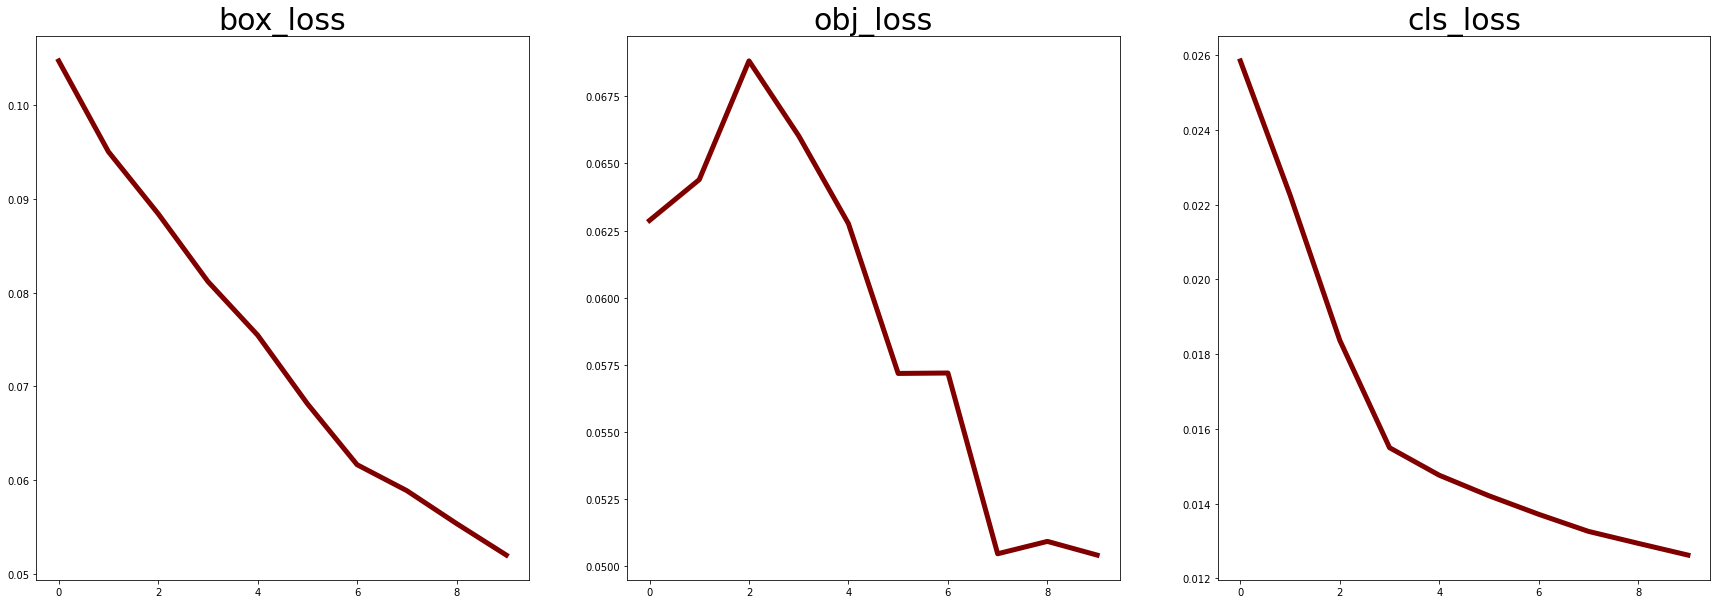

In [36]:
losses = columns_list[:3]

titles = ['box_loss', 'obj_loss', 'cls_loss']

plot_graphs_yolov5(losses, titles, 'maroon')

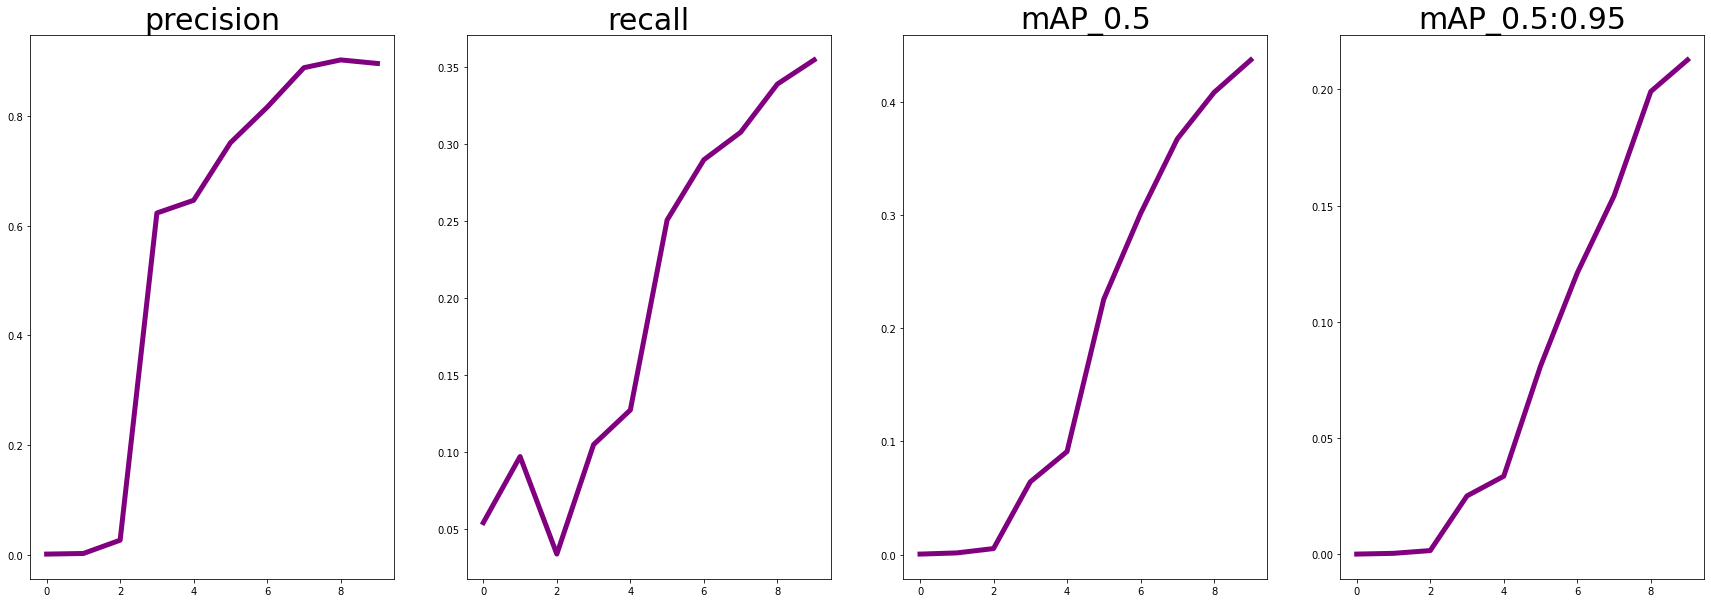

In [37]:
metrics = columns_list[3:7]

titles = ['precision', 'recall', 'mAP_0.5', 'mAP_0.5:0.95']

plot_graphs_yolov5(metrics, titles, 'purple')

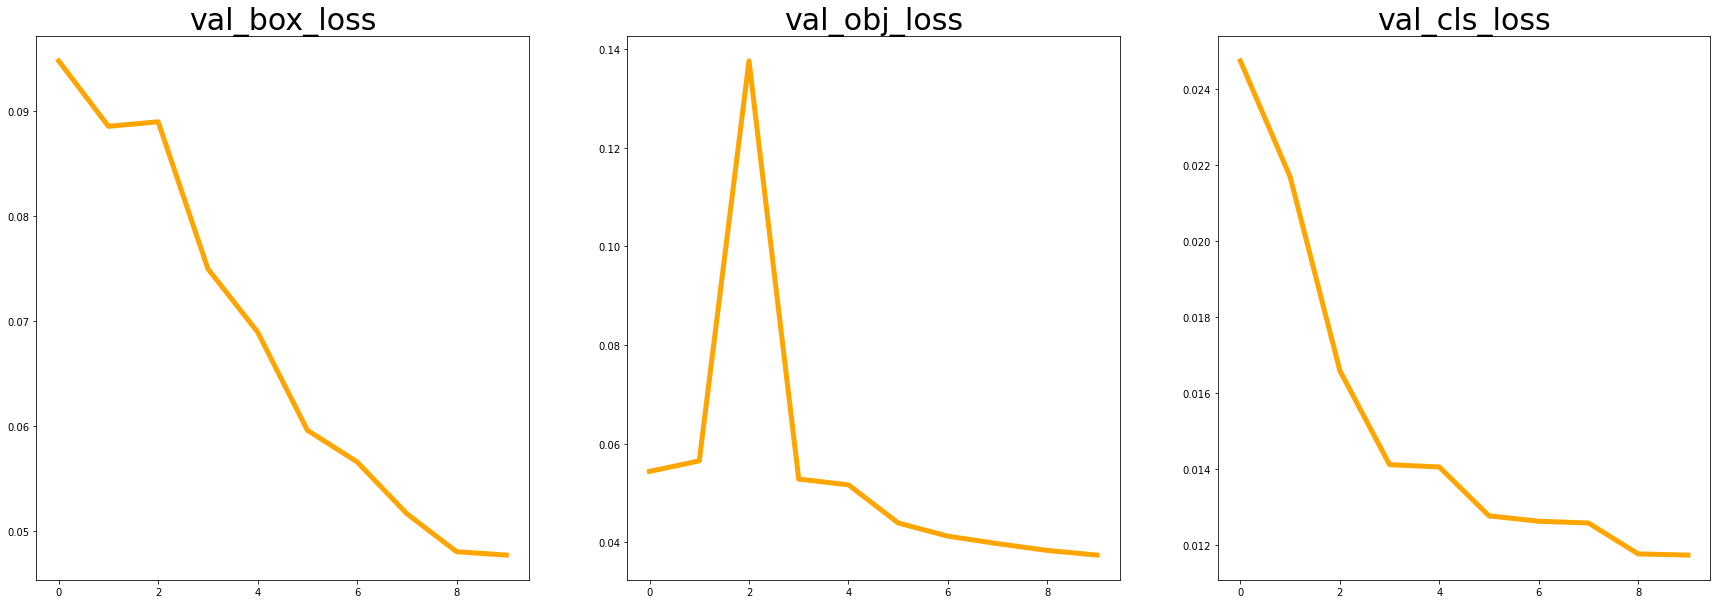

In [38]:
validation = columns_list[7:10]

titles = ['val_box_loss', 'val_obj_loss', 'val_cls_loss']

plot_graphs_yolov5(validation, titles, 'orange')

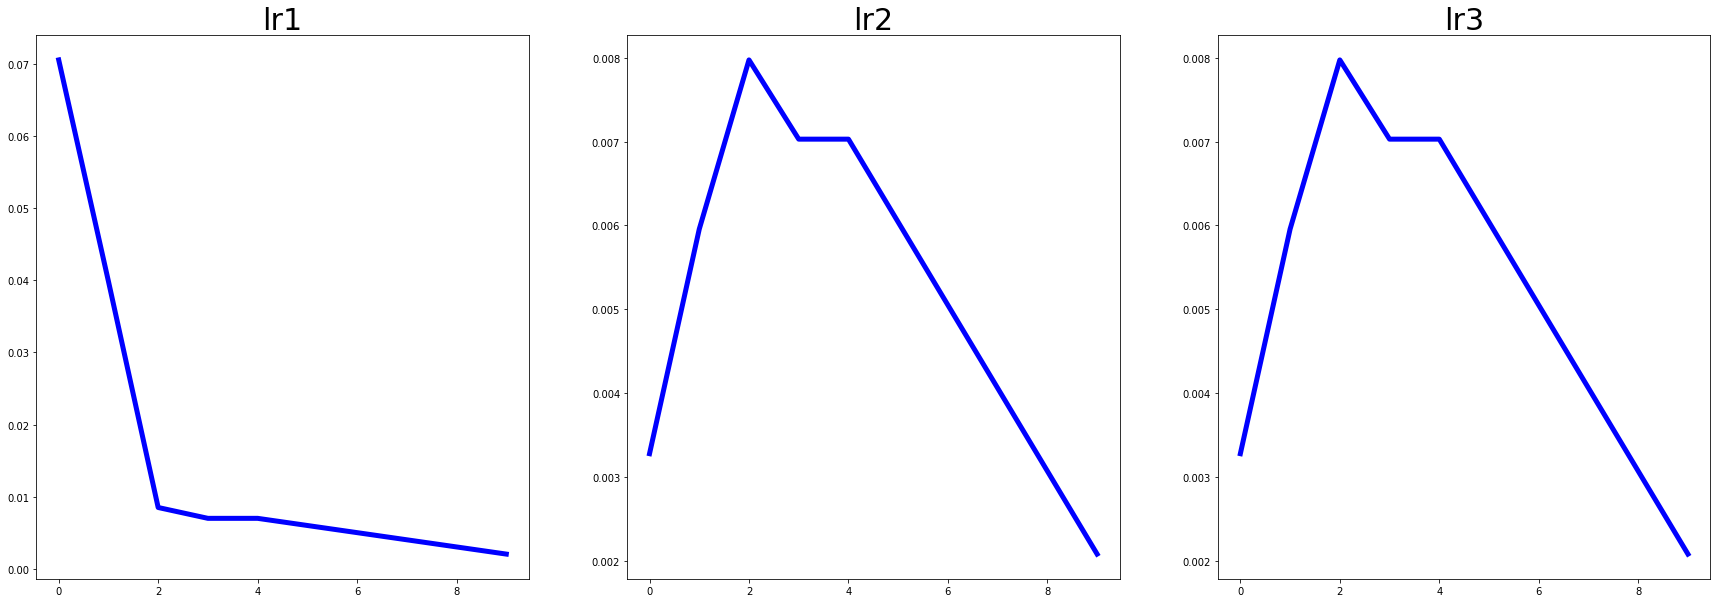

In [39]:
learning_rates = columns_list[10:13]

titles = ['lr1', 'lr2', 'lr3']

plot_graphs_yolov5(learning_rates, titles, 'blue')

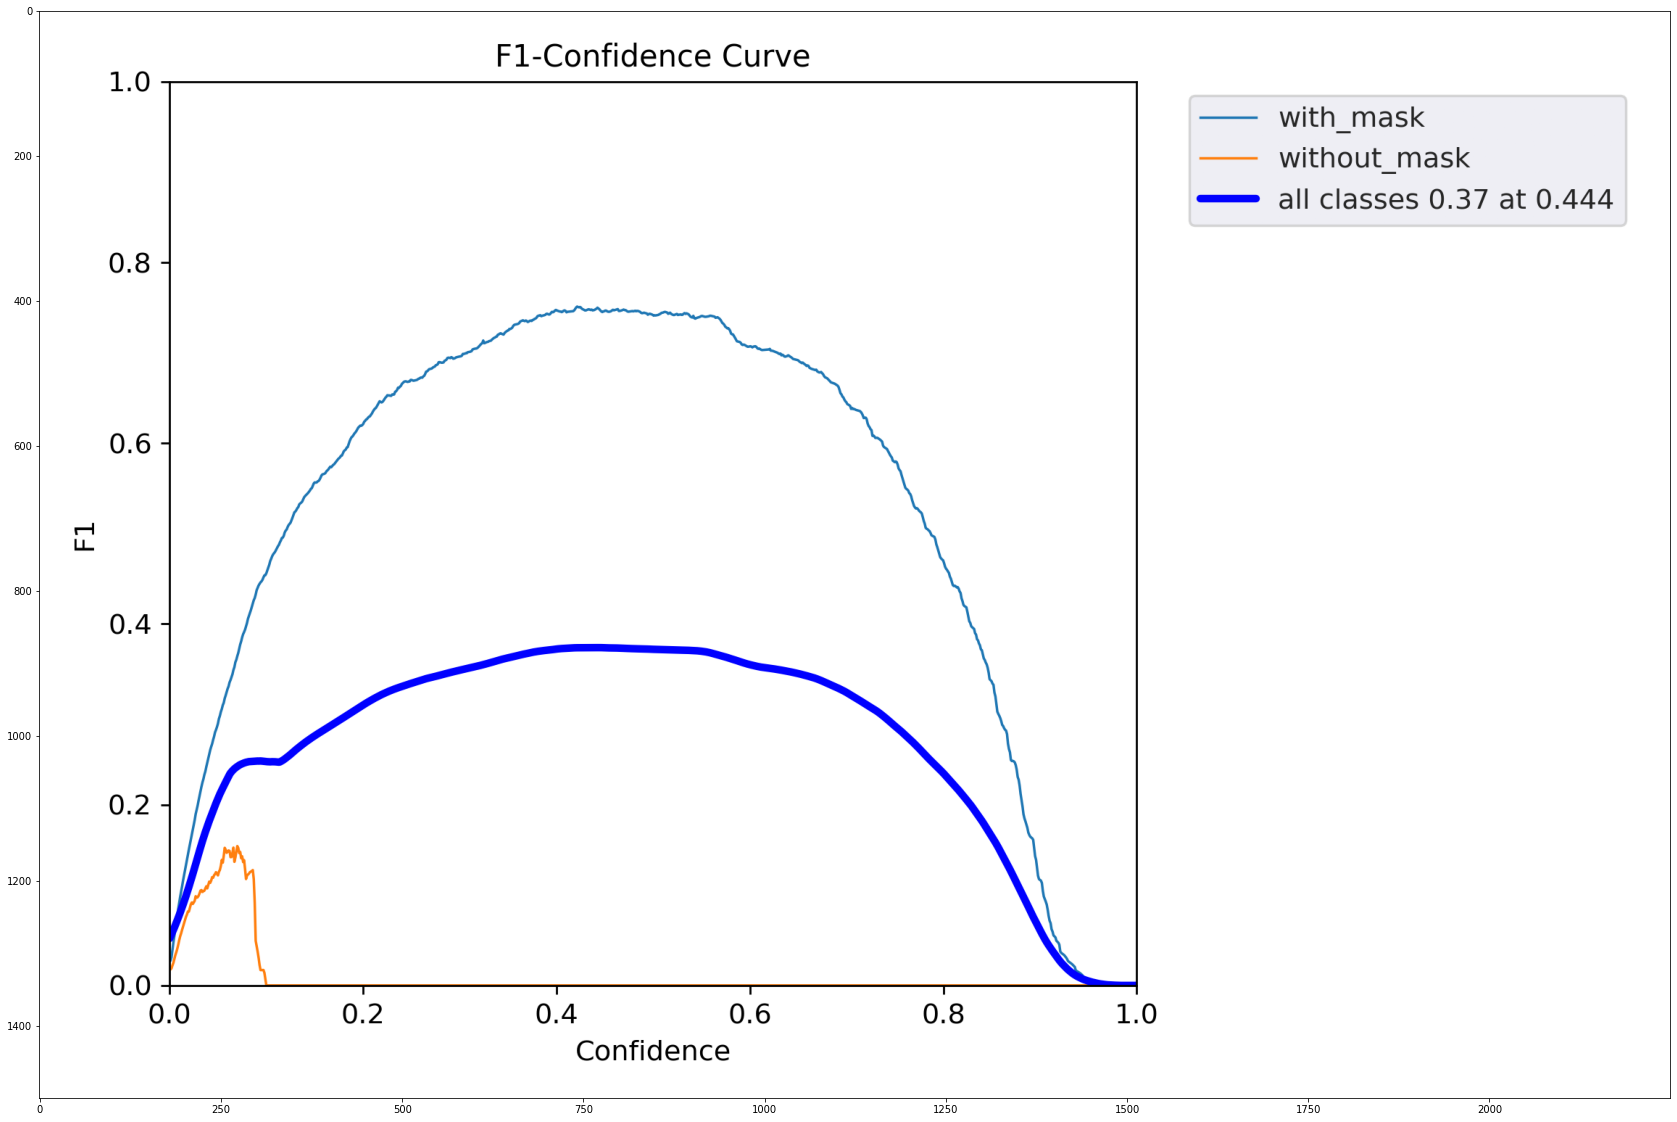

In [41]:
img = plt.imread('runs/train/yolov5s_results3/F1_curve.png')
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.show()

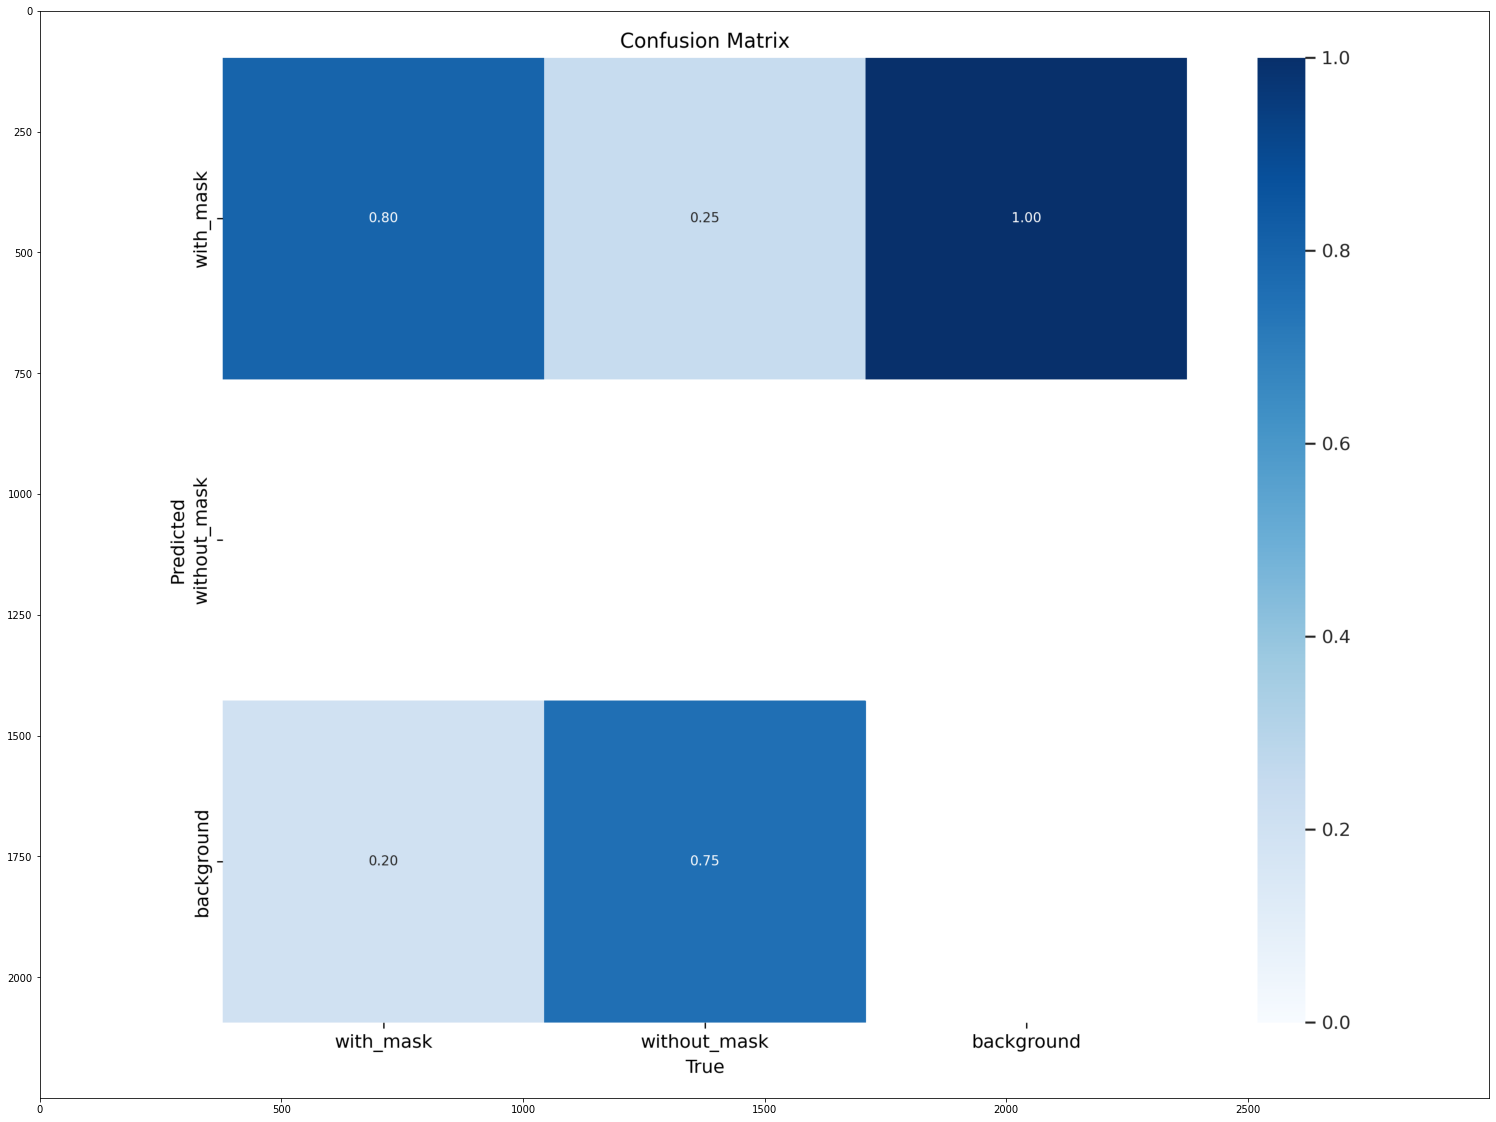

In [43]:
img = plt.imread('runs/train/yolov5s_results3/confusion_matrix.png')
plt.figure(figsize=(30,20))
plt.imshow(img)
plt.show()

In [46]:
!python /content/yolov5/detect.py --source /content/gdrive/MyDrive/masks/test/images --weight /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'], source=/content/gdrive/MyDrive/masks/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
image 1/89 /content/gdrive/MyDrive/masks/test/images/maksssksksss121.jpg: 480x640 1 with_mask, 350.1ms
image 2/89 /content/gdrive/MyDrive/masks/test/images/maksssksksss122.jpg: 480x640 2 with_masks, 318.6ms
image 3/89 /content/gdrive/MyDrive/masks/test/images/maksssksksss149.jpg: 480x640 6 with_masks, 306.6ms
image

In [47]:
color_dict = {
    'with_mask': (0, 255, 0),
    'without_mask': (255, 0, 0) 
}

In [51]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = '/content/gdrive/MyDrive/masks/test/images/'+img_id# +'.jpg'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    # results are saved inside run/detect/expTestImage dir
    img_pred = plt.imread('/content/yolov5/runs/detect/expTestImage2/'+img_id)
    # ===================================
    plt.figure(figsize=(30,20))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Test image')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')

In [1]:
for i in os.listdir("/content/yolov5/runs/detect/expTestImage2"):
    show_image(i) 
    plt.show()

NameError: ignored